# DNNs and CNNs using Kuzushiji-MNIST

* **Project:** M3: Mini Project
* **Author:** Jacob Buysse

In this project we will explore the Kuzushiji-MNIST dataset: a drop-in replacement for MNIST using 10 classes of Kuzushiji (cursive Japanese).
* [Source Paper](https://nips2018creativity.github.io/doc/deep_learning_for_classical_japanese_literature.pdf)

In this notebook we will be using...

In [28]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Let us load the datasets and take a look at the data.

In [16]:
train_X = np.load('./kmnist-train-imgs.npz')['arr_0']
train_y = np.load('./kmnist-train-labels.npz')['arr_0']
test_X = np.load('./kmnist-test-imgs.npz')['arr_0']
test_y = np.load('./kmnist-test-labels.npz')['arr_0']

In [17]:
print(f"Train X {train_X.shape}, y {train_y.shape}, Test X {test_X.shape}, y {test_y.shape}")

Train X (60000, 28, 28), y (60000,), Test X (10000, 28, 28), y (10000,)


So we have 60,000 28x28 training images with classes and 10,000 28x28 testing images with classes.  Let us look at a few items from some of the classes.

In [24]:
df_train_y = pd.DataFrame(train_y)
df_train_y.value_counts()

0
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: count, dtype: int64

We have a balanced class distribution with 6,000 images per each of the 10 classes 0 through 9.

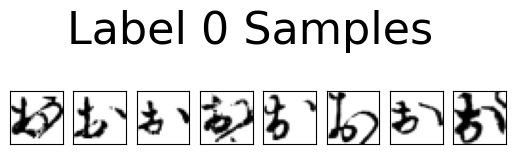

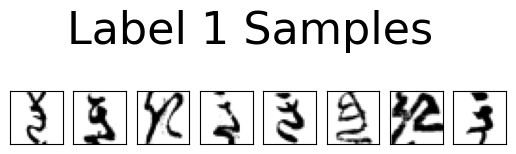

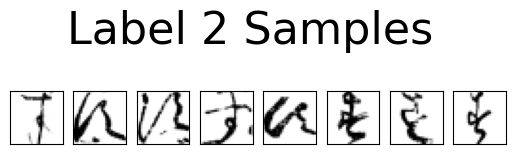

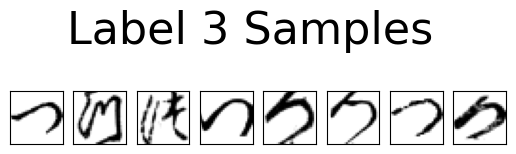

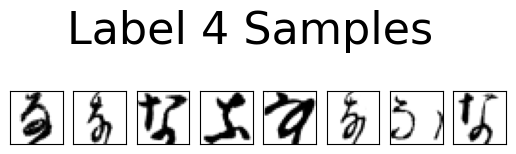

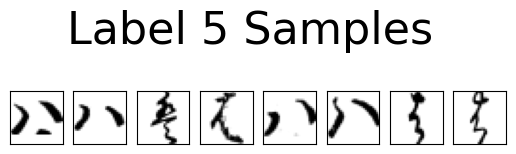

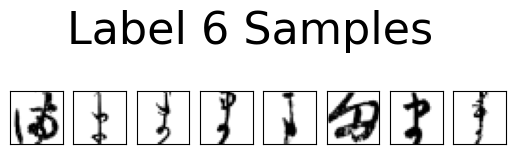

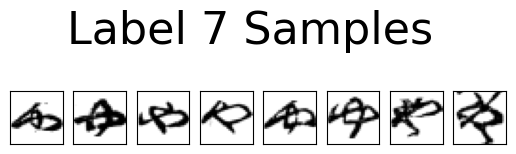

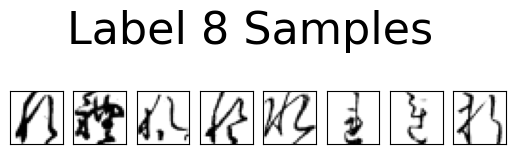

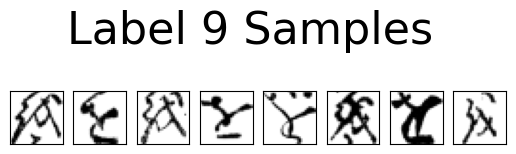

In [64]:
def show_class(label, count=8):
    images = train_X[df_train_y[0] == label]
    fig, axarr = plt.subplots(1, count)
    for index in range(0, count):
        pixels = images[index]
        axarr[index].imshow(pixels, cmap='gray_r', vmin=0, vmax=255)
        axarr[index].tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig.suptitle(f"Label {label} Samples", fontsize=32)
    plt.subplots_adjust(top=1.4)
    plt.show()
for label in range(0, 10):
    show_class(label)